In [1]:
# Import packages
from tools.to_read import *
from tools.to_plot import *
from tools.to_do import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.image as mpimg

# Set up
root='/home/jacoponudo/Documents/Size_effects/'
platforms = ['reddit', 'usenet', 'voat','gab', 'facebook','twitter']
platforms=['facebook']
platform ='gab' #input('Please enter the value for platform: ')

# Read data
data = pd.read_parquet(root + 'DATA/' + platform + '/'+platform+'_raw_data.parquet', columns=columns_to_read[platform])
data.columns=standard_columns
data['timestamp'] = pd.to_datetime(data['timestamp'])

/home/jacoponudo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Plot 1

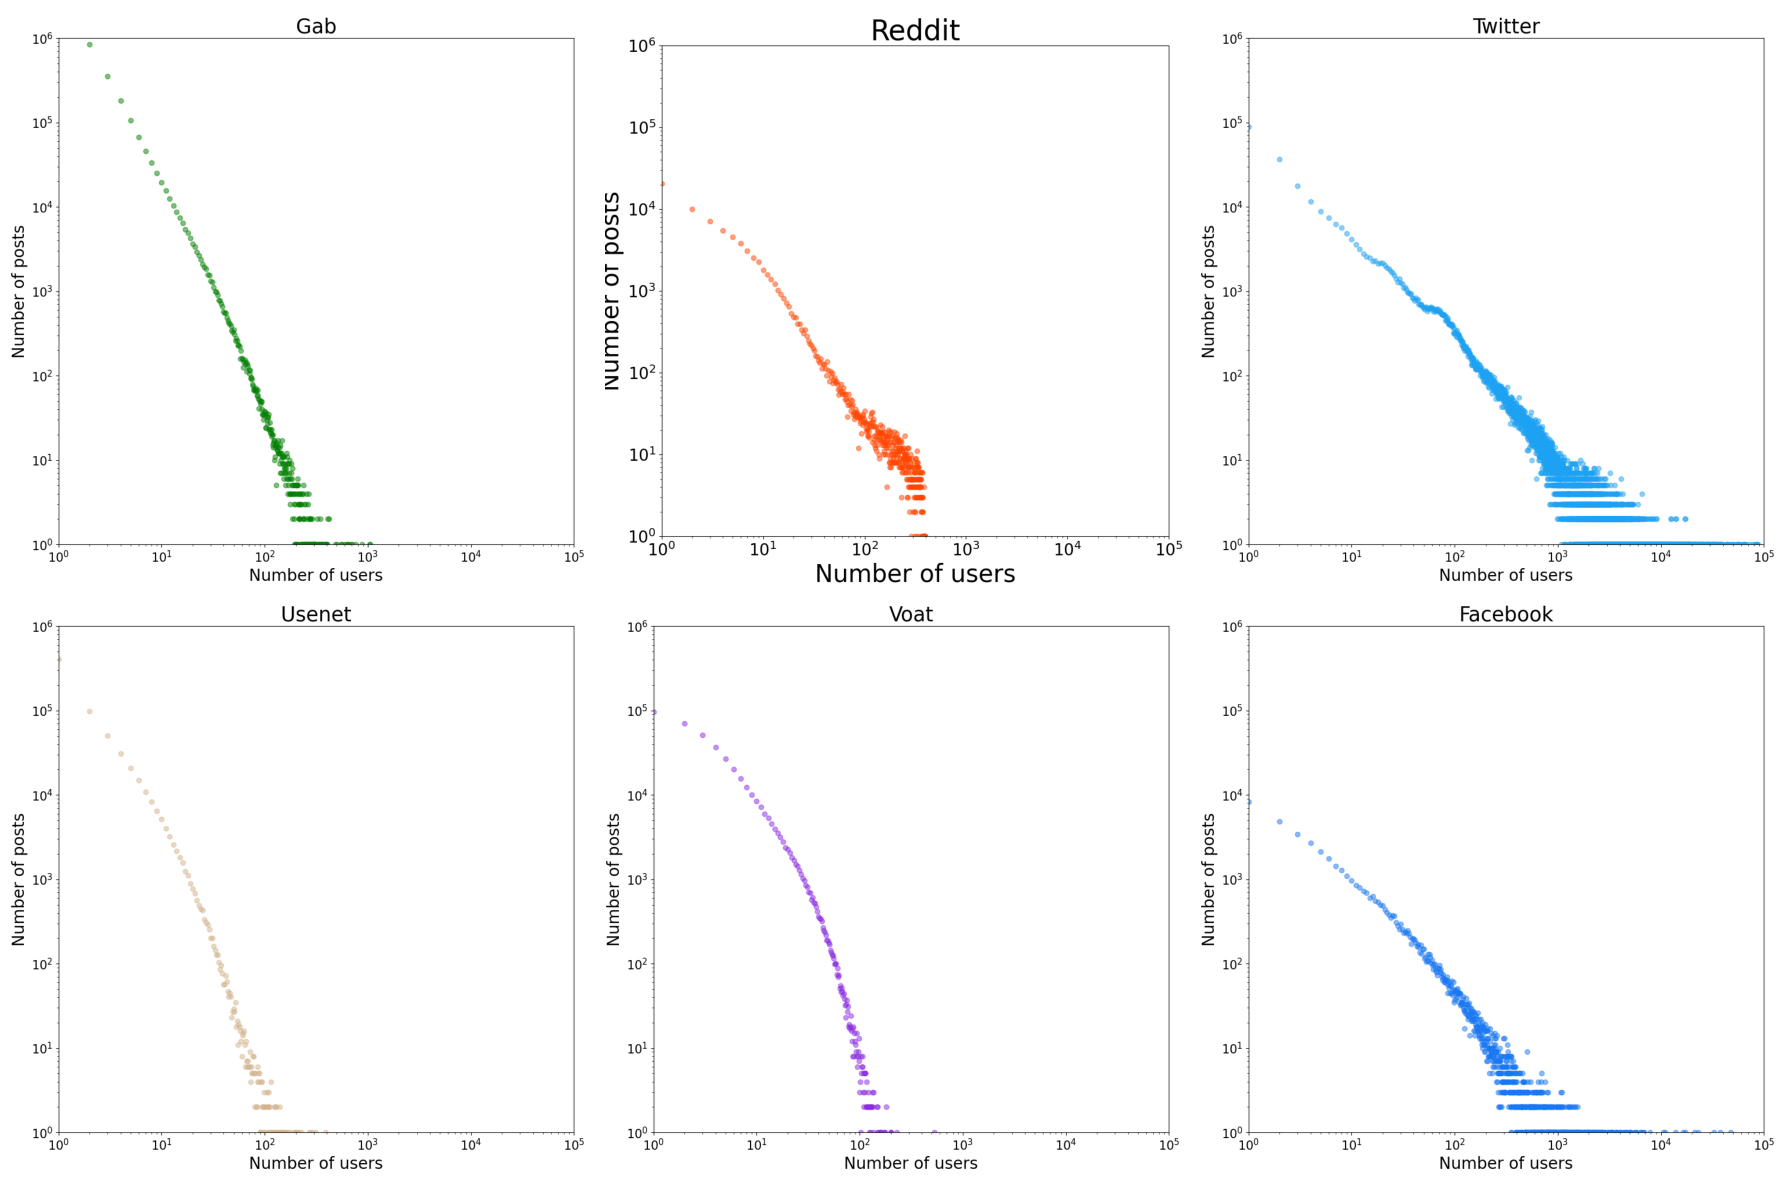

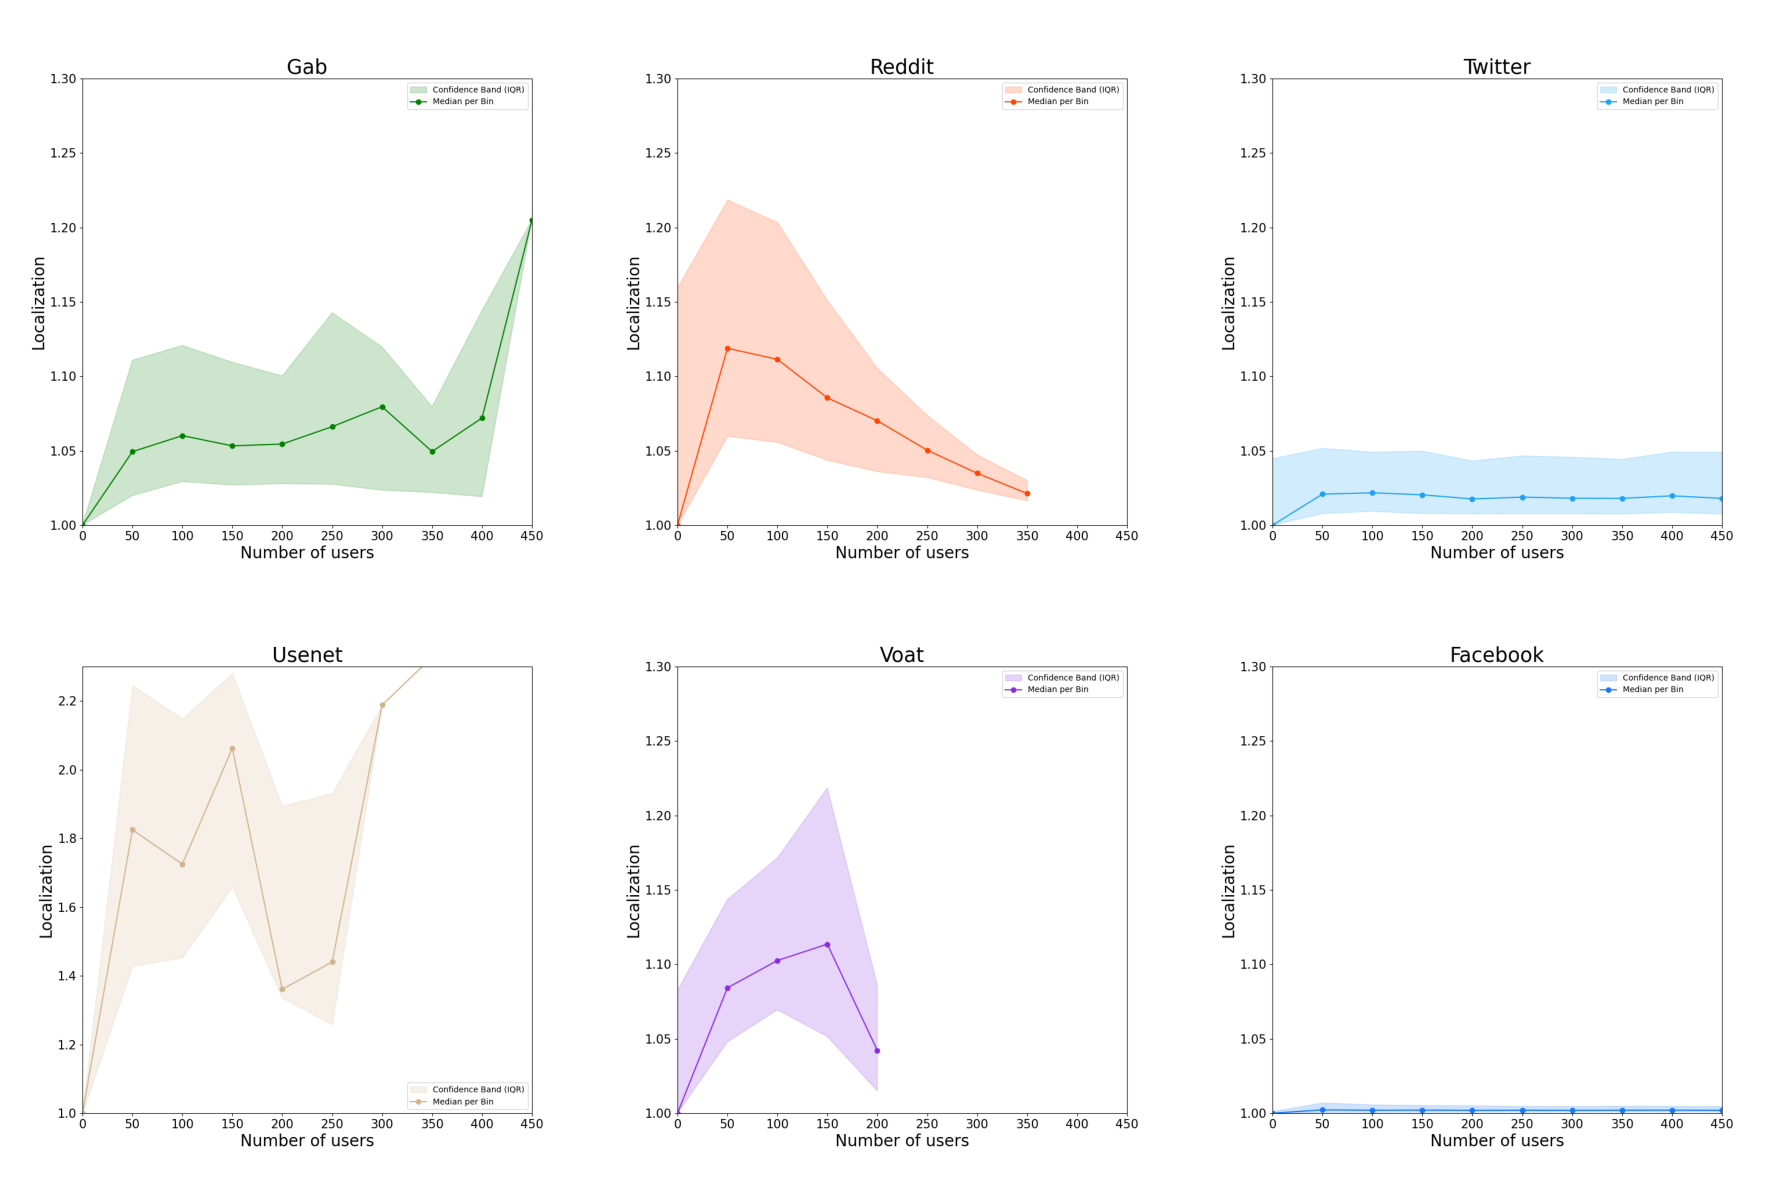

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['1_users_in_thread','4_dialogue_level'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [root + 'PAPER/output/1_section/' + plot + '_gab.png', 
              root + 'PAPER/output/1_section/' + plot + '_reddit.png', 
              root + 'PAPER/output/1_section/' + plot + '_twitter.png',
            root + 'PAPER/output/1_section/' + plot + '_usenet.png',
              root + 'PAPER/output/1_section/' + plot + '_voat.png',
              root + 'PAPER/output/1_section/' + plot + '_facebook.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/1_section/' + plot[0] + '.png'
    plt.savefig(combined_image_path)
    plt.show()

### Plot 2

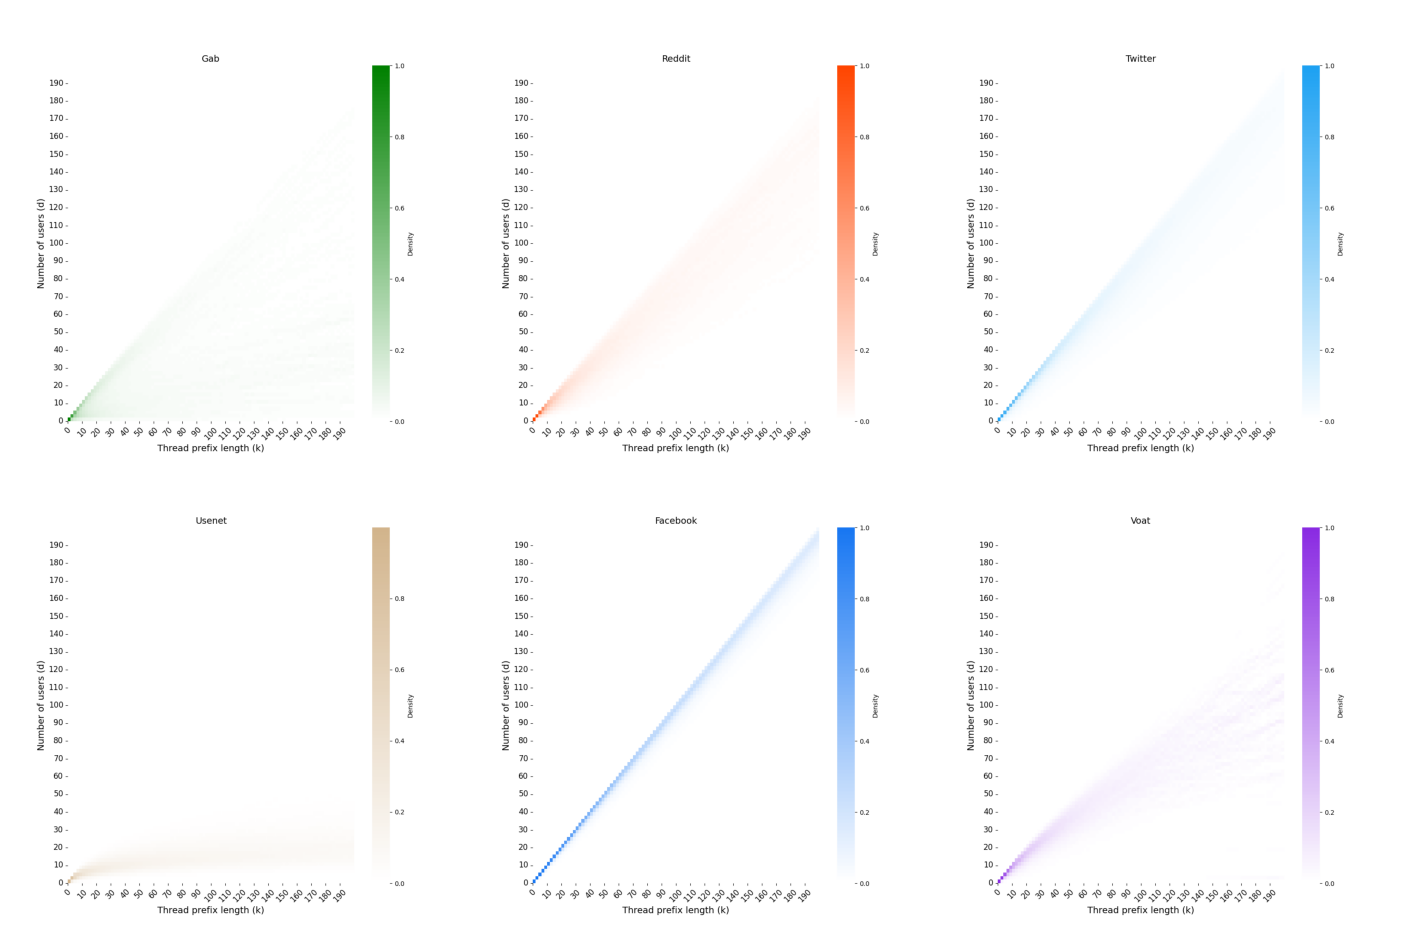

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['heatmap']  # You can add more plot types here if needed

for plot in plots:
    images = [
        root + 'PAPER/output/2_section/' + plot + '_gab.png', 
        root + 'PAPER/output/2_section/' + plot + '_usenet.png', 
        root + 'PAPER/output/2_section/' + plot + '_reddit.png',
        root + 'PAPER/output/2_section/' + plot + '_voat.png',
        root + 'PAPER/output/2_section/' + plot + '_facebook.png',
        root + 'PAPER/output/2_section/' + plot + '_twitter.png'
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Completely remove spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0)  # No whitespace between plots

    # Save the combined image
    combined_image_path = root + 'PAPER/output/2_section/' + plot + '.png'
    plt.savefig(combined_image_path, bbox_inches='tight')
    plt.show()


In [ ]:
# Initialize a list to store the localization data
localization_data = []

# Process each platform and store the results
for platform in (platforms):
    df = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', columns=columns_to_read[platform])
    df.columns = standard_columns
    df['date'] = pd.to_datetime(df['timestamp'])
    
    # Create a year-week column for grouping
    df['year'] = df['date'].dt.year
    df['week'] = df['date'].dt.isocalendar().week

    # Drop rows where date conversion failed
    df = df.dropna(subset=['year', 'week'])

    # Get unique years
    years_unique = df['year'].unique()

    for year in tqdm(years_unique):
        for week in range(1, 54):  # Loop through each week (ISO weeks range from 1 to 53)
            # Filter data for the specific year and week
            weekly_data = df[(df['year'] == year) & (df['week'] == week)]
            
            # Check if there are at least 100 rows in the weekly dataset
            if len(weekly_data) < 100:
                continue  # Skip this week if there are fewer than 100 rows
            
            # Group by user and post to count the occurrences of comments (or other interactions)
            counts = weekly_data.groupby(['user_id', 'post_id'])['date'].count().reset_index()
            
            # Calculate histogram for PDF
            hist, _ = np.histogram(counts['date'], bins=np.arange(1, 11, 1), density=True)
            
            # Calculate the Localization parameter L (replace with your actual calculation)
            localization_value = calculate_localization_parameter(hist)  # Ensure this function is defined
            
            # Create a datetime object representing the start of the week for the x-axis
            start_of_week = pd.to_datetime(f'{year}-W{week:02d}-1', format='%G-W%V-%u')  # ISO week date format
            localization_data.append({'Platform': platform, 
                                       'Date': start_of_week,  # Convert to datetime
                                       'Localization': localization_value, 'Platform': platform})
localization_df = pd.DataFrame(localization_data)
# Save each platform's data to a separate CSV
for platform in localization_df['Platform'].unique():
    # Filter data for the specific platform
    platform_data = localization_df[localization_df['Platform'] == platform]
    
    # Save to CSV with the platform name
    platform_data.to_csv(f'{platform}_localization.csv', index=False)

100%|██████████| 8/8 [01:48<00:00, 13.54s/it]


## Plot5

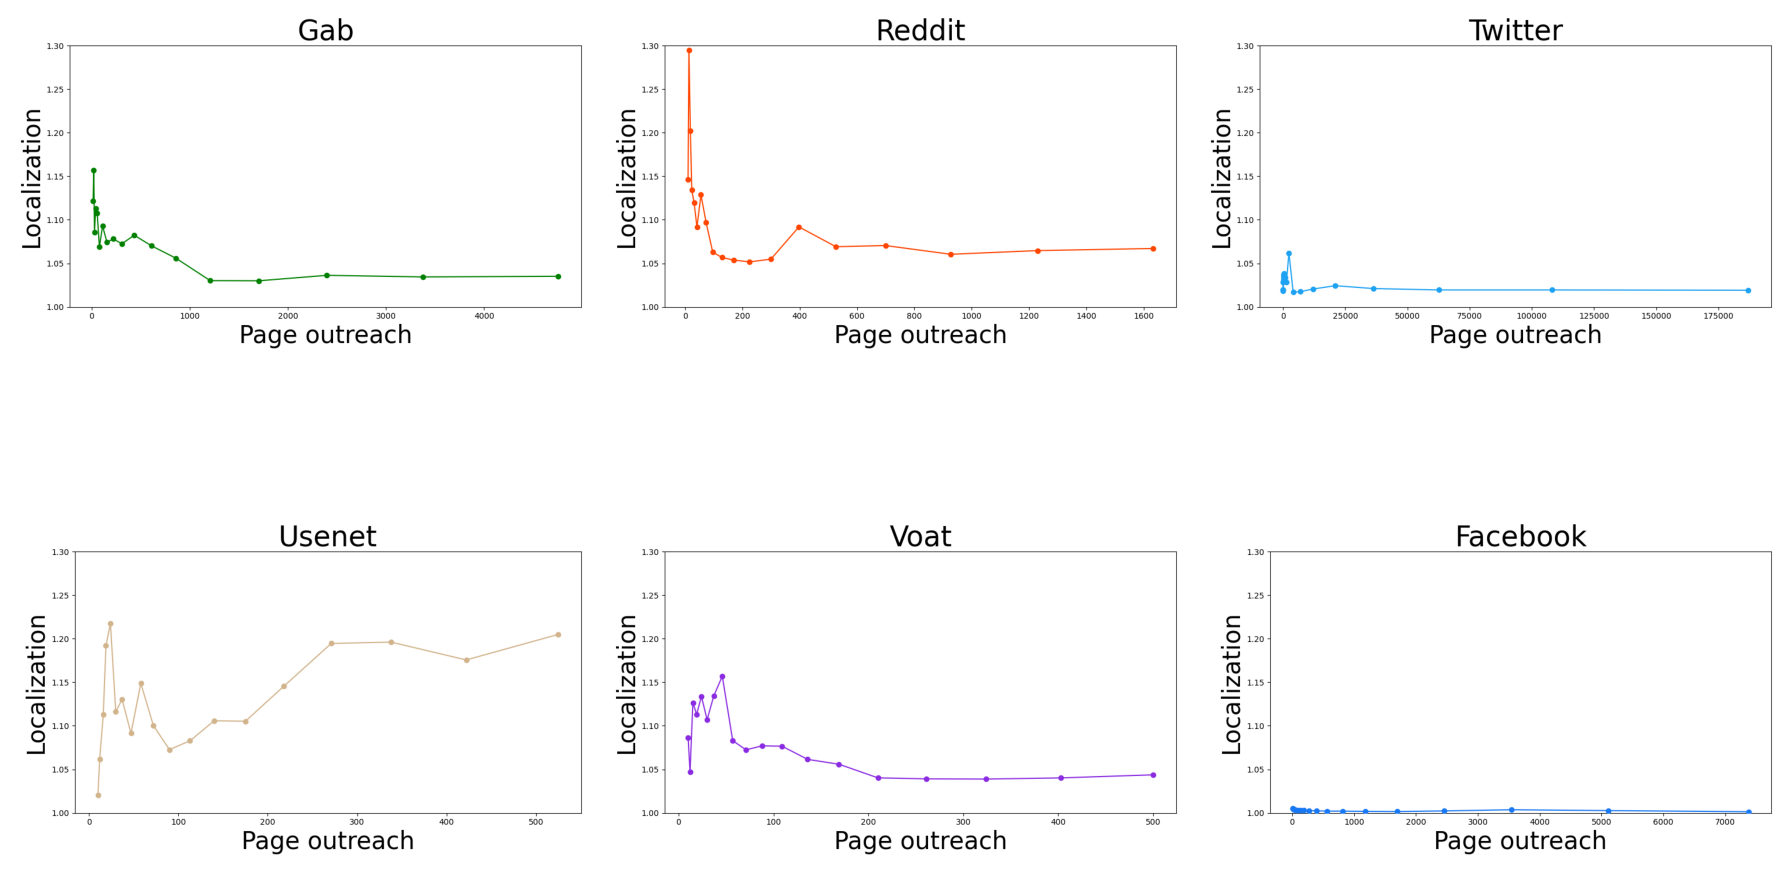

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plots = ['5_size_effect'] #['1_users_in_thread', '2_lifetime_thread', '3_concentration_of_comments', '4_dialogue_level']

for i,plot in enumerate(plots):
    images = [root + 'PAPER/output/4_section/' + plot + '_gab.png', 
              root + 'PAPER/output/4_section/' + plot + '_reddit.png', 
              root + 'PAPER/output/4_section/' + plot + '_twitter.png',
            root + 'PAPER/output/4_section/' + plot + '_usenet.png',
              root + 'PAPER/output/4_section/' + plot + '_voat.png',
              root + 'PAPER/output/4_section/' + plot + '_facebook.png']
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for ax, img_path in zip(axes.flat, images):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis('off')  

    # Adjust layout
    plt.tight_layout()

    # Save the combined image
    combined_image_path = root + 'PAPER/output/4_section/' + plot[0] + '.png'
    plt.savefig(combined_image_path)
    plt.show()

<Figure size 1000x500 with 0 Axes>

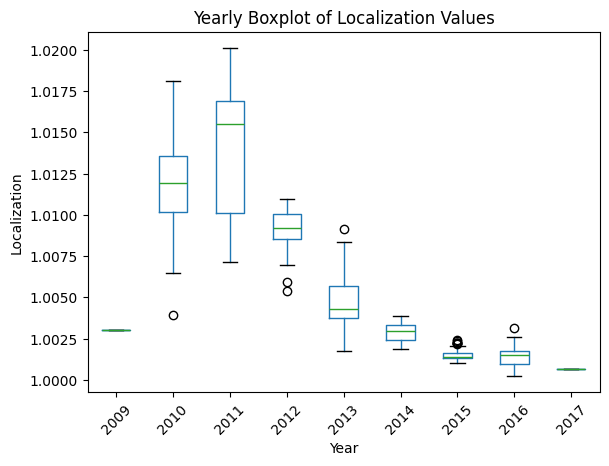

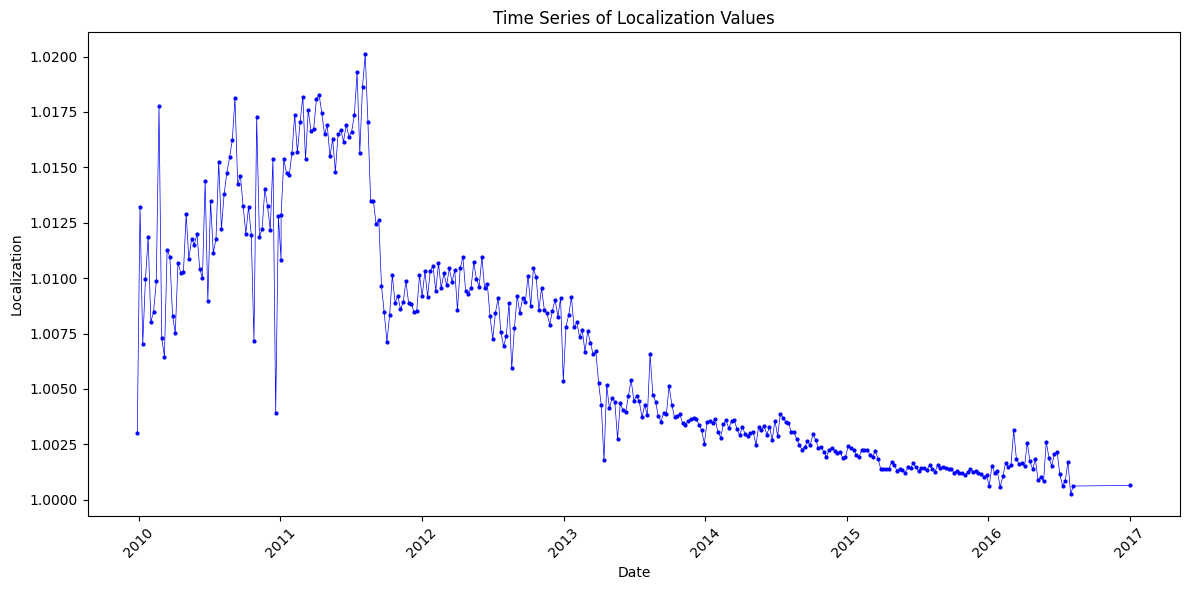

In [3]:
df=pd.DataFrame(localization_data)
# Boxplot
plt.figure(figsize=(10, 5))
df = df.sort_values(by='Date')

df['year'] = df['Date'].dt.year  # Extract year for grouping
df.boxplot(column='Localization', by='year', grid=False)
plt.title('Yearly Boxplot of Localization Values')
plt.suptitle('')  # Remove the default 'by' title
plt.xlabel('Year')
plt.ylabel('Localization')
plt.xticks(rotation=45)
plt.show()

# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Localization'], marker='o', markersize=2, linestyle='-', linewidth=0.5, color='b')
plt.title('Time Series of Localization Values')
plt.xlabel('Date')
plt.ylabel('Localization')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
# Initialize a list to store the localization data
localization_data = []

# Process each platform and store the results
for platform in tqdm(platforms):
    df = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', columns=columns_to_read[platform])
    df.columns = standard_columns
    df['date'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    
    # Drop rows where date conversion failed
    df = df.dropna(subset=['year', 'month', 'day'])
    
    # Get unique years
    years_unique = df['year'].unique()
    
    for year in years_unique:
        for month in range(1, 13):  # Loop through each month
            for day in range(1, 32):  # Loop through each day
                # Filter data for the specific year, month, and day
                daily_data = df[(df['year'] == year) & (df['month'] == month) & (df['day'] == day)]
                
                # Check if there are at least 100 rows in the daily dataset
                if len(daily_data) < 100:
                    continue  # Skip this day if there are fewer than 100 rows
                
                # Group by user and post to count the occurrences of comments (or other interactions)
                counts = daily_data.groupby(['user_id', 'post_id'])['date'].count().reset_index()
                
                # Calculate histogram for PDF
                hist, _ = np.histogram(counts['date'], bins=np.arange(1, 11, 1), density=True)
                
                # Calculate the Localization parameter L (replace with your actual calculation)
                localization_value = calculate_localization_parameter(hist)  # Ensure this function is defined
                
                # Create a datetime object for the x-axis
                date_str = f"{int(year)}-{month:02d}-{day:02d}"  # Ensure year is an integer
                localization_data.append({'Platform': platform, 
                                           'Date': pd.to_datetime(date_str),  # Convert to datetime
                                           'Localization': localization_value})


  0%|          | 0/6 [00:08<?, ?it/s]


KeyboardInterrupt: 

# Dinamiche collettive 

#### 1. Numero di utenti coinvolti in una conversazione

In [2]:
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index()
unique_users_per_post.columns = ['post_id', 'unique_users_count']
unique_users_per_post.to_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))

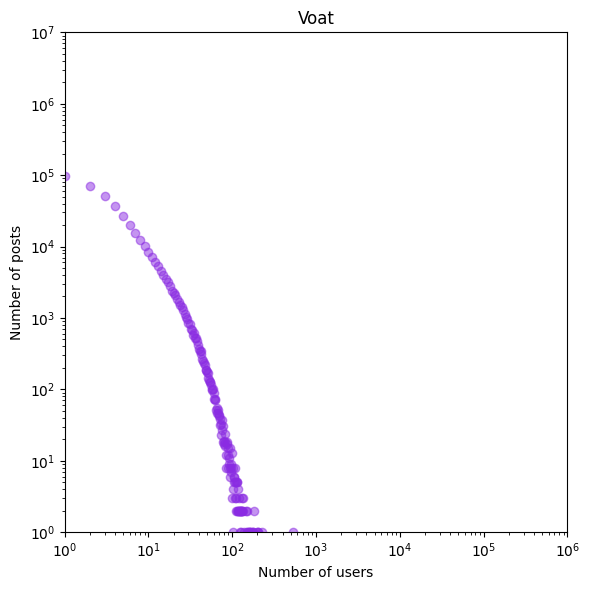

In [3]:
# Assuming the root and platform variables are defined
unique_users_per_post = pd.read_csv(root+'PAPER/output/1_section/1_users_in_thread_{}.csv'.format(platform))
distribution = unique_users_per_post['unique_users_count'].value_counts().sort_index()

plt.figure(figsize=(6, 6))
plt.scatter(distribution.index, distribution.values, color=palette[platform], alpha=0.5)  # Alpha added for transparency
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10**6)  # Set x-axis limits between 1 and 10^6
plt.ylim(1, 10**7)  # Set y-axis limits between 1 and 10^6
plt.xlabel('Number of users')
plt.ylabel('Number of posts')
plt.title(str(platform.capitalize()))
plt.grid(False)
plt.tight_layout()

plt.savefig(root+'PAPER/output/1_section/1_users_in_thread_{}.png'.format(platform))
plt.show()

#### 2. Durata della conversazione

In [4]:


# Esempio di utilizzo: calcolare il 95° percentile e salvare il file
output_path =root+'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
calculate_lifetime_percentile(data, 80, output_path)

Calcolando durata 80° percentile per ogni post: 100%|██████████| 413854/413854 [02:40<00:00, 2578.67it/s]


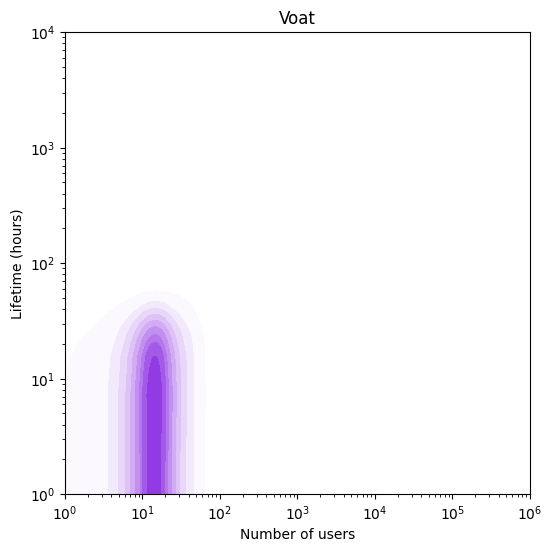

In [ ]:

# Load the data
output_path = root + 'PAPER/output/1_section/2_lifetime_thread_{}.csv'.format(platform)
df = pd.read_csv(output_path, dtype={'post_id': str})

# Remove NA values from the 'duration_percentile' column
df = df.dropna(subset=['duration_percentile','unique_user_count'])
# Filter rows where 'unique_user_count' is greater than 50
df = df[df['unique_user_count'] > 10]
df=df.sample(5000)


# Create the density plot
plt.figure(figsize=(6, 6))
sns.kdeplot(
    data=df, 
    x="unique_user_count",
    y="duration_percentile",  
    fill=True, 
    cmap=LinearSegmentedColormap.from_list("platform_to_white", ['white', palette[platform]])
)
plt.title(str(platform.capitalize()))
plt.ylabel('Lifetime (hours)')
plt.xlabel('Number of users')

# Set log scale for both axes
plt.xscale('log')
plt.yscale('log')

# Limit the x-axis between 0 and 10^6, and y-axis between 0 and 10^4
plt.xlim(1, 10**6)
plt.ylim(1, 10**4)


# Save the plot
plt.savefig(root + 'PAPER/output/1_section/2_lifetime_thread_{}.png'.format(platform))
plt.show()


#### 3. Concentration of the conversation

In [6]:
# Conta il numero di utenti univoci per ciascun post
unique_users_per_post = data.groupby('post_id')['user_id'].nunique().reset_index(name='unique_user_count')

# Calcola la concentrazione assoluta massima e relativa dei commenti (come già mostrato)
data['hour'] = data['timestamp'].dt.floor('H')
comments_per_hour = data.groupby(['post_id', 'hour']).size().reset_index(name='comment_count')
max_concentration = comments_per_hour.groupby('post_id')['comment_count'].max().reset_index(name='max_absolute_concentration')

total_comments = data.groupby('post_id').size().reset_index(name='total_comments')
results_df = pd.merge(max_concentration, total_comments, on='post_id')
results_df['relative_concentration'] = results_df['max_absolute_concentration'] / results_df['total_comments']

# Aggiungi il conteggio degli utenti univoci
results_df = pd.merge(results_df, unique_users_per_post, on='post_id')

# Salva il risultato
results_df.to_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))


/tmp/ipykernel_783132/2980163939.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data['hour'] = data['timestamp'].dt.floor('H')


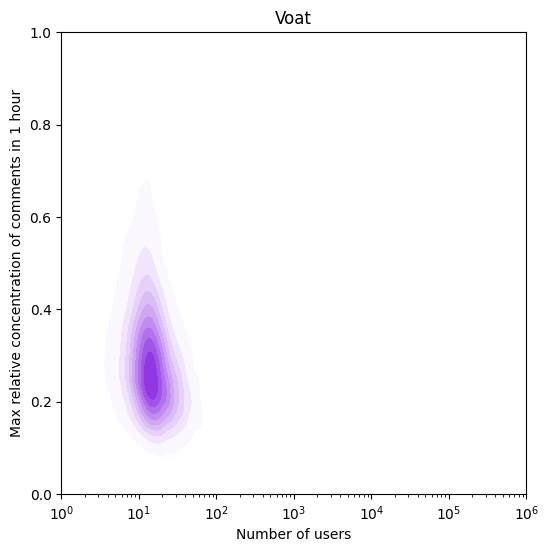

In [7]:
results_df=pd.read_csv(root+'PAPER/output/1_section/3_concentration_of_comments_{}.csv'.format(platform))



filtered_results_df = results_df[results_df['unique_user_count'] > 10]
filtered_results_df=filtered_results_df.sample(5000)
platform_color = palette[platform]  # Ad esempio, il colore arancione che volevi usare

# Definire una scala di colori che parte da 'platform_color' e termina con il bianco
cmap = LinearSegmentedColormap.from_list("platform_to_white", [ 'white',platform_color])

# Supponiamo che il tuo dataframe si chiami 'filtered_results_df'
plt.figure(figsize=(6, 6))
sns.kdeplot(x=filtered_results_df['unique_user_count'], y=filtered_results_df['relative_concentration'], cmap=cmap, fill=True)

plt.title(str(platform.capitalize()))
plt.ylabel('Max relative concentration of comments in 1 hour')
plt.xlabel('Number of users')
plt.xscale('log')
plt.xlim(1, 10**6)
plt.ylim(0,1)
plt.grid(False)

plt.savefig(root+'PAPER/output/1_section/3_concentration_of_comments_{}.png'.format(platform))
plt.show()


#### 4. Level of dialogue

In [3]:
grouped = data.groupby(['user_id', 'post_id']).size().reset_index(name='comment_count')
user_count = data.groupby('post_id')['user_id'].nunique().reset_index(name='user_count')
result = grouped.merge(user_count, on='post_id', how='left')
bins = np.arange(0, 1020, 50)
result['user_count_bin'] = pd.cut(result['user_count'], bins=bins, right=False)
valid_bins = result['user_count_bin'].value_counts()[result['user_count_bin'].value_counts() > 100].index
result = result[result['user_count_bin'].isin(valid_bins)]
result['comment_count'] = result['comment_count'].apply(lambda x: 5 if x > 5 else x)
prob_dist = result.groupby(['user_count_bin', 'post_id'])['comment_count'].value_counts(normalize=True)

localization_results = prob_dist.groupby(['user_count_bin', 'post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')
localization_results.to_csv(root + f'PAPER/output/1_section/4_dialogue_level_{platform}.csv')

/tmp/ipykernel_212350/2497360174.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prob_dist = result.groupby(['user_count_bin', 'post_id'])['comment_count'].value_counts(normalize=True)
/tmp/ipykernel_212350/2497360174.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  localization_results = prob_dist.groupby(['user_count_bin', 'post_id']).apply(lambda x: calculate_localization_parameter(x.values)).reset_index(name='localization_parameter')


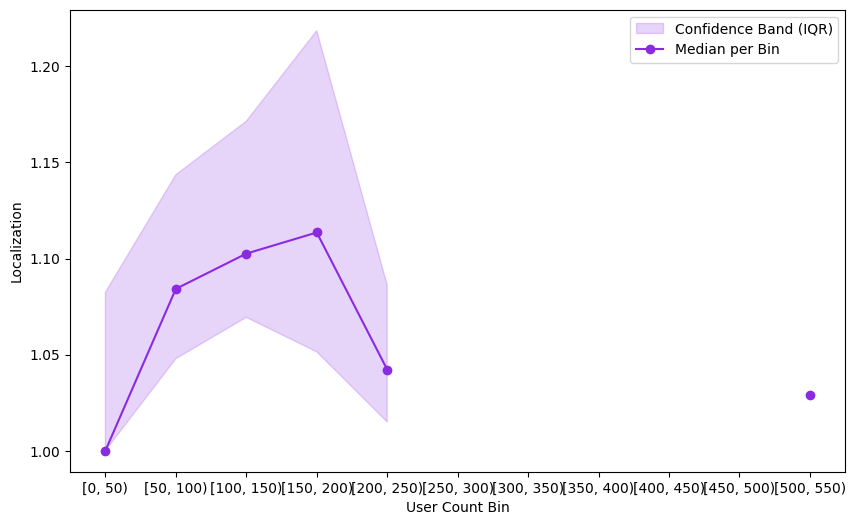

In [10]:
# Load the data
localization_results = pd.read_csv(f"{root}PAPER/output/1_section/4_dialogue_level_{platform}.csv")

# Group data by 'user_count_bin' and calculate median, Q1, and Q3 for 'localization_parameter'
median_values = localization_results.groupby('user_count_bin')['localization_parameter'].median().reset_index()
q1_values = localization_results.groupby('user_count_bin')['localization_parameter'].quantile(0.25).reset_index()
q3_values = localization_results.groupby('user_count_bin')['localization_parameter'].quantile(0.75).reset_index()

# Merge median, Q1, and Q3 values into a single DataFrame
conf_interval = pd.merge(median_values, q1_values[['user_count_bin', 'localization_parameter']], on='user_count_bin', suffixes=('', '_Q1'))
conf_interval = pd.merge(conf_interval, q3_values[['user_count_bin', 'localization_parameter']], on='user_count_bin', suffixes=('', '_Q3'))

# Sort values by 'user_count_bin' (converting to numeric if necessary)
localization_results['bin_lower_bound'] = localization_results['user_count_bin'].str.extract(r'(\d+)').astype(float)
conf_interval = conf_interval.merge(localization_results[['user_count_bin', 'bin_lower_bound']].drop_duplicates(), on='user_count_bin')
conf_interval = conf_interval.sort_values(by='bin_lower_bound').reset_index(drop=True)

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(conf_interval['user_count_bin'], conf_interval['localization_parameter_Q1'], conf_interval['localization_parameter_Q3'], color=palette[platform], alpha=0.2, label='Confidence Band (IQR)')
plt.plot(conf_interval['user_count_bin'], conf_interval['localization_parameter'], marker='o', color=palette[platform], label='Median per Bin')

# Add labels and legend
plt.xlabel('User Count Bin')
plt.ylabel('Localization')
plt.legend()
plt.savefig(root+'PAPER/output/1_section/4_dialogue_level_{}.png'.format(platform))
plt.show()

Processing gab: 100%|██████████| 100/100 [00:00<00:00, 120.61it/s]
/tmp/ipykernel_325236/1931197710.py:33: RuntimeWarning: invalid value encountered in divide
  density_matrix /= density_matrix.sum(axis=1, keepdims=True)


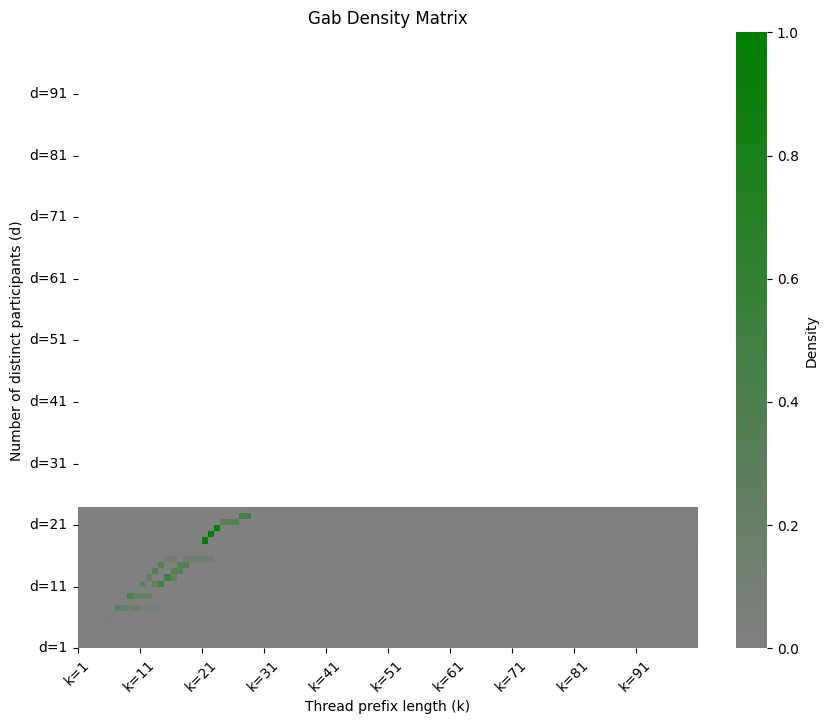

Processing reddit: 100%|██████████| 100/100 [00:00<00:00, 123.11it/s]
/tmp/ipykernel_325236/1931197710.py:33: RuntimeWarning: invalid value encountered in divide
  density_matrix /= density_matrix.sum(axis=1, keepdims=True)


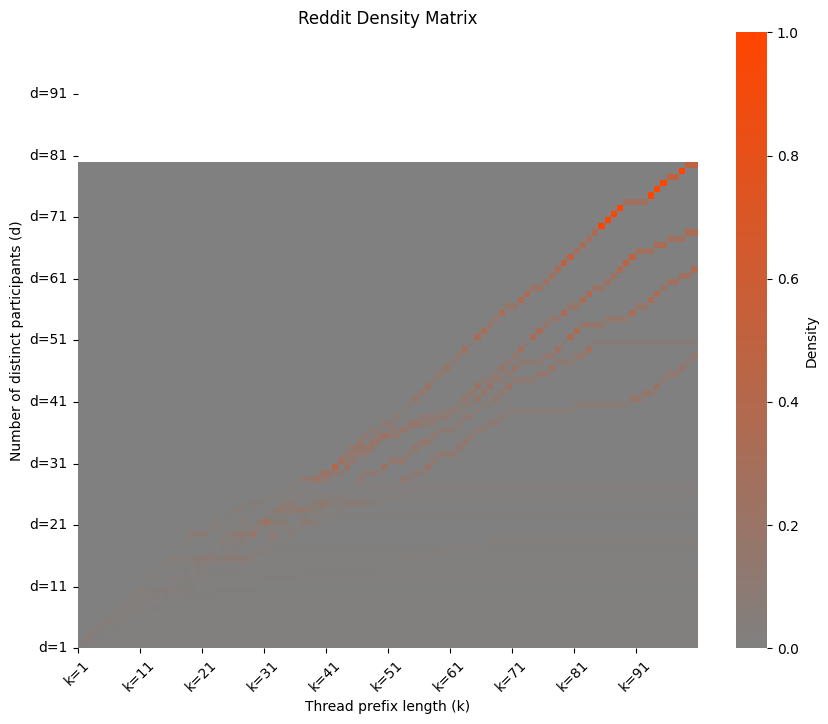

Processing twitter: 100%|██████████| 100/100 [00:00<00:00, 122.24it/s]
/tmp/ipykernel_325236/1931197710.py:33: RuntimeWarning: invalid value encountered in divide
  density_matrix /= density_matrix.sum(axis=1, keepdims=True)


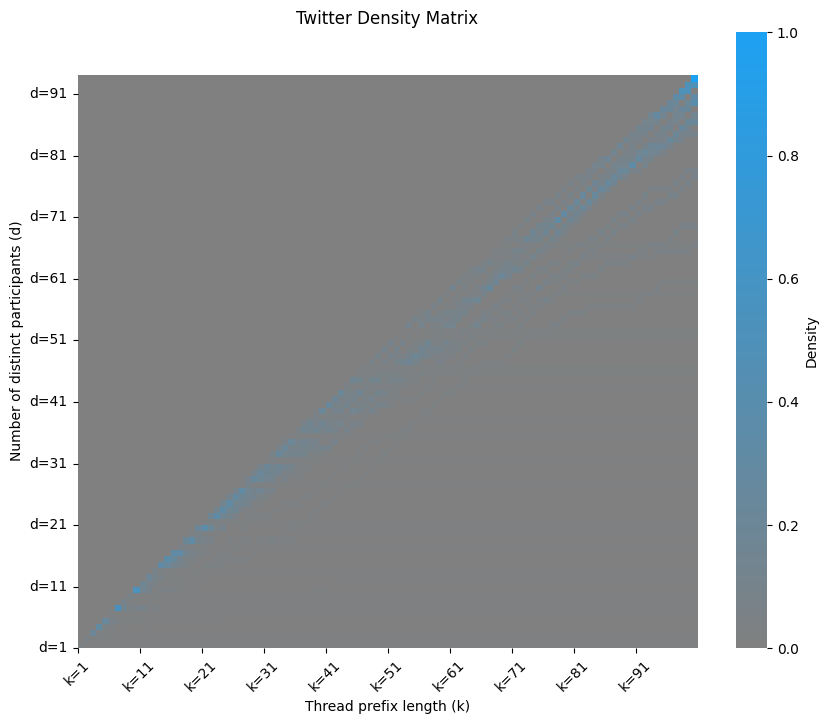

Processing usenet: 100%|██████████| 100/100 [00:00<00:00, 117.00it/s]
/tmp/ipykernel_325236/1931197710.py:33: RuntimeWarning: invalid value encountered in divide
  density_matrix /= density_matrix.sum(axis=1, keepdims=True)


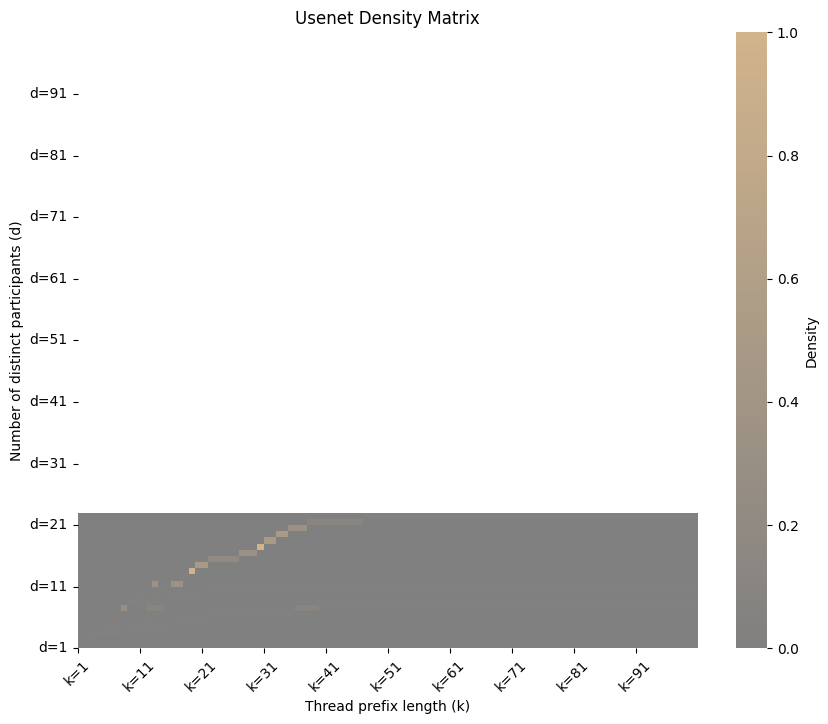

Processing voat: 100%|██████████| 100/100 [00:00<00:00, 121.62it/s]
/tmp/ipykernel_325236/1931197710.py:33: RuntimeWarning: invalid value encountered in divide
  density_matrix /= density_matrix.sum(axis=1, keepdims=True)


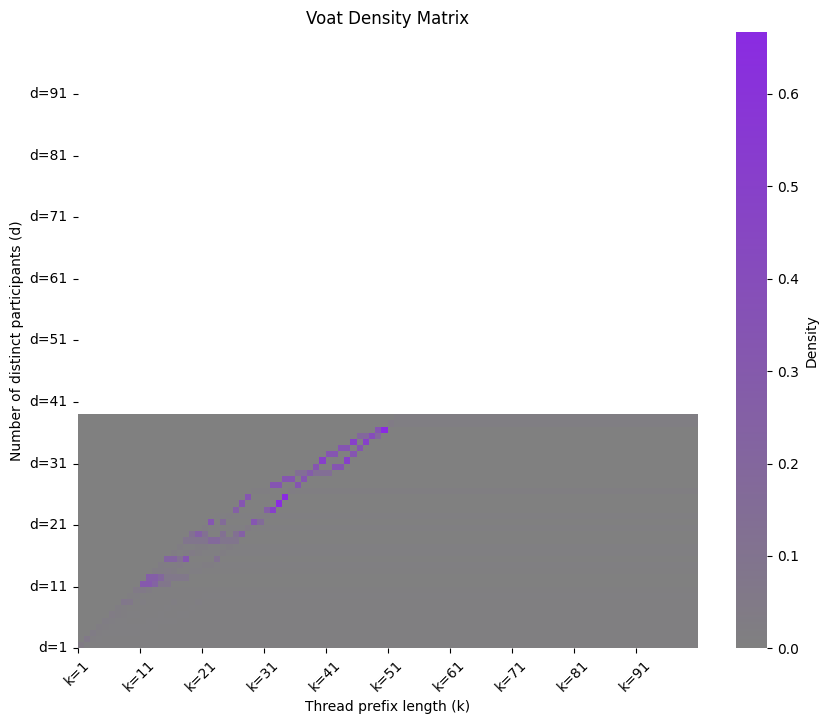

Processing facebook:  91%|█████████ | 91/100 [00:00<00:00, 119.75it/s]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib.colors import LinearSegmentedColormap

platforms = ['gab', 'reddit', 'twitter', 'usenet', 'voat', 'facebook']
for platform in platforms:
    data = pd.read_parquet(root + 'DATA/' + platform + '/' + platform + '_raw_data.parquet', columns=columns_to_read[platform])
    data.columns = standard_columns
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    df = data.sort_values(by=['post_id', 'timestamp'])
    sampled_posts = np.random.choice(df['post_id'].unique(), min(len(df['post_id'].unique()), 100), replace=False)
    df = df[df['post_id'].isin(sampled_posts)]

    max_k = 100
    max_d = 100
    density_matrix = np.zeros((max_d, max_k))

    for post_id, group in tqdm(df.groupby('post_id'), desc=f"Processing {platform}"):
        group = group.sort_values(by='timestamp')
        for k in range(1, max_k + 1):
            top_k_comments = group.head(k)
            distinct_users_count = top_k_comments['user_id'].nunique()
            if distinct_users_count <= max_d:
                density_matrix[distinct_users_count - 1, k - 1] += 1

    # Normalizzazione per colonna
    density_matrix /= density_matrix.sum(axis=0, keepdims=True)

    # Normalizzazione per riga
    density_matrix /= density_matrix.sum(axis=1, keepdims=True)

    density_df = pd.DataFrame(density_matrix, columns=[f"k={i}" for i in range(1, max_k + 1)],
                              index=[f"d={i}" for i in range(1, max_d + 1)])
    density_df.to_csv(f"/home/jacoponudo/Documents/Size_effects/PAPER/output/2_section/density_matrix_{platform}.csv", index=True)

    plt.figure(figsize=(10, 8))
    platform_color = palette[platform]
    cmap = LinearSegmentedColormap.from_list("platform_to_white", ['grey', platform_color])
    sns.heatmap(density_matrix, cmap=cmap,
                cbar_kws={'label': 'Density'},
                xticklabels=range(1, max_k + 1),
                yticklabels=range(1, max_d + 1))

    plt.xlabel("Thread prefix length (k)")
    plt.ylabel("Number of distinct participants (d)")
    plt.title(f"{platform.capitalize()} Density Matrix")

    # Riduci il numero di etichette dell'asse x e y visualizzate
    plt.xticks(ticks=np.arange(0, max_k, step=10), labels=[f"{i}" for i in range(1, max_k + 1, 10)], rotation=45)
    plt.yticks(ticks=np.arange(0, max_d, step=10), labels=[f"{i}" for i in range(1, max_d + 1, 10)])
    
    plt.gca().invert_yaxis()
    plt.savefig(f"/home/jacoponudo/Documents/Size_effects/PAPER/output/2_section/heatmap_{platform}.png")
    plt.show()
plt.close()  # Close the plot to free up memory

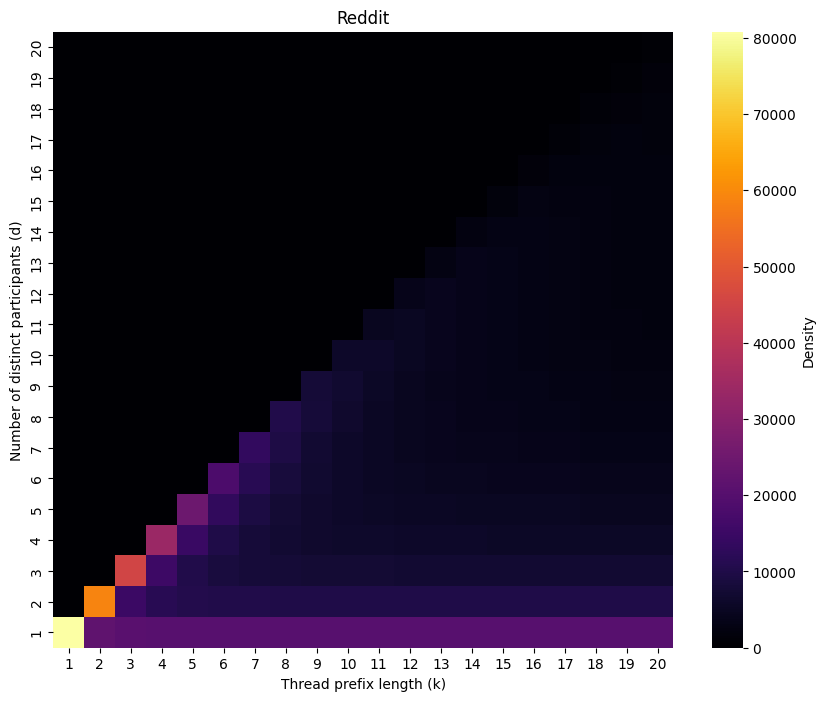

In [21]:
# Normalize the density matrix for color scale
density_matrix2 = density_matrix / density_matrix.sum(axis=1, keepdims=True)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(density_matrix, cmap="inferno", cbar=True, 
            cbar_kws={'label': 'Density'}, 
            xticklabels=range(1, max_k + 1), 
            yticklabels=range(1, max_d + 1))

plt.xlabel("Thread prefix length (k)")
plt.ylabel("Number of distinct participants (d)")
plt.title(str(platform.capitalize()))

# Invert y-axis to start from the bottom
plt.gca().invert_yaxis()

plt.show()


In [5]:
density_matrix2

array([[1.     , 0.17868, 0.167  , ..., 0.16542, 0.16542, 0.16542],
       [0.     , 0.82132, 0.12462, ..., 0.09666, 0.09666, 0.09666],
       [0.     , 0.     , 0.70838, ..., 0.06884, 0.06884, 0.06884],
       ...,
       [0.     , 0.     , 0.     , ..., 0.04736, 0.04562, 0.03222],
       [0.     , 0.     , 0.     , ..., 0.     , 0.0454 , 0.04446],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.04354]])

In [8]:
density_matrix
density_matrix / density_matrix.sum(axis=2, keepdims=True)

array([[0.07470471, 0.02024577, 0.01909862, ..., 0.01884626, 0.01884626,
        0.01884626],
       [0.        , 0.10820232, 0.02742433, ..., 0.01826697, 0.01826697,
        0.01826697],
       [0.        , 0.        , 0.11458405, ..., 0.017977  , 0.017977  ,
        0.017977  ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.08666667, 0.34666667,
        0.56666667],
       [0.        , 0.        , 0.        , ..., 0.        , 0.1875    ,
        0.8125    ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])